In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device_id = 0
is_cuda = torch.cuda.is_available()
print(is_cuda)
if is_cuda:
    torch.cuda.set_device(device_id)
is_cuda = False

True


## 1. LR

In [3]:
# trainset = pd.read_csv('../input/trainSet.csv')
# testset = pd.read_csv('../input/test set.csv')

In [4]:
# epochs = 1
# X, y = trainset.iloc[:, :32].values, trainset.iloc[:, 32].values
# print(X.size, y.size)
# model = LogisticRegression(solver='liblinear')
# for epoch in range(epochs):
#     model.fit(X, y)
#     predicted = model.predict(X)
#     train_loss = metrics.log_loss(y, predicted)
#     train_accuracy = metrics.accuracy_score(y, predicted)
#     message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
#                                                                 epochs, train_loss, train_accuracy)
#     print(message)
# arr = model.predict(testset.values)
# df = pd.DataFrame({ 'id': range(1, arr.size + 1), 'Predicted': arr })
# df.to_csv('./lr.csv', index=False)

> ## 2. NN

In [5]:
class CsvDataset(Dataset):
    def __init__(self, csv_file, include_label=False, transform=None):
        frame = pd.read_csv(csv_file)
        # self.data = preprocessing.minmax_scale(frame, feature_range=(-10, 10))
        self.data = preprocessing.scale(frame.iloc[:, :32])
        if include_label:
            self.label = frame.iloc[:, 32]
        self.include_label = include_label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        feature = np.array(self.data[i, :32])
        if self.include_label:
            label = 1 if self.label[i] > 0 else 0
        else:
            label = 0
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, label)

In [6]:
batch_size = 1000
trainset = CsvDataset('../input/trainSet.csv', include_label=True, transform=torch.tensor)
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False)

testset = CsvDataset('../input/test set.csv', include_label=False, transform=torch.tensor)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(NeuralNetwork, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(in_size, hidden_size),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(hidden_size),
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(hidden_size // 2),
#             nn.Linear(hidden_size // 2, out_size),
#             nn.Sigmoid()
#         )
        self.layer = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer(x)
        return x

In [8]:
def train(trainloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.type('torch.FloatTensor').to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = total_loss / (batch_idx + 1)
    return average_loss

def evaluate(testloader, model, loss_fn, device):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.type('torch.FloatTensor').to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    average_loss = test_loss / (batch_idx + 1)
    return average_loss, correct / total

In [9]:
def fit(trainloader, model, loss_fn, optimizer, scheduler, epochs, device):
    train_accs = []
    train_losses = []
    
    for epoch in range(epochs):
        train_loss = train(trainloader, model, loss_fn, optimizer, device)
        _, train_accuracy = evaluate(trainloader, model, loss_fn, device)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                epochs, train_loss, train_accuracy)
        print(message)
    
        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        
        scheduler.step()
    return train_accs, train_losses

In [10]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

In [11]:
def weight_bias_reset(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            mean, std = 0, 0.1 
            torch.nn.init.normal_(m.weight, mean, std)
            torch.nn.init.normal_(m.bias, mean, std)

Epoch: 1/200. Train set: Average loss: 0.6956, Accuracy: 0.5154
Epoch: 2/200. Train set: Average loss: 0.6884, Accuracy: 0.5156
Epoch: 3/200. Train set: Average loss: 0.6820, Accuracy: 0.5157
Epoch: 4/200. Train set: Average loss: 0.6762, Accuracy: 0.5158
Epoch: 5/200. Train set: Average loss: 0.6737, Accuracy: 0.5159
Epoch: 6/200. Train set: Average loss: 0.6726, Accuracy: 0.5159
Epoch: 7/200. Train set: Average loss: 0.6720, Accuracy: 0.5159
Epoch: 8/200. Train set: Average loss: 0.6716, Accuracy: 0.5160
Epoch: 9/200. Train set: Average loss: 0.6713, Accuracy: 0.5160
Epoch: 10/200. Train set: Average loss: 0.6710, Accuracy: 0.5162
Epoch: 11/200. Train set: Average loss: 0.6709, Accuracy: 0.5163
Epoch: 12/200. Train set: Average loss: 0.6707, Accuracy: 0.5165
Epoch: 13/200. Train set: Average loss: 0.6706, Accuracy: 0.5169
Epoch: 14/200. Train set: Average loss: 0.6705, Accuracy: 0.5180
Epoch: 15/200. Train set: Average loss: 0.6704, Accuracy: 0.5202
Epoch: 16/200. Train set: Average 

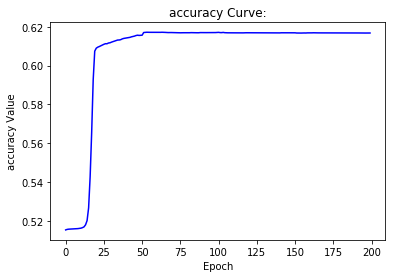

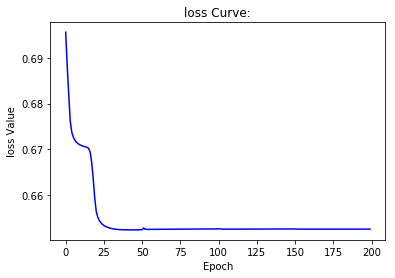

In [12]:
epochs = 200
learning_rate = 0.001
hidden_size = 256
device = 'cuda:0' if is_cuda else 'cpu'

model = NeuralNetwork(32, hidden_size, 2)
if is_cuda:
    model = model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
# loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
weight_bias_reset(model)
train_accs, train_losses = fit(trainloader, model, loss_fn, optimizer, scheduler, epochs, device)
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')

In [13]:
def get_test_result(testloader, model, device):
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(testloader):
            inputs = inputs.type('torch.FloatTensor').to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            if batch_idx == 0:
                result = predicted
            else:
                result = torch.cat([result, predicted], 0)
        print(result.sum())
    return result

In [14]:
result = get_test_result(testloader, model, device)
arr = result.cpu().numpy()
df = pd.DataFrame({ 'id': range(1, arr.size + 1), 'Predicted': arr })
df.to_csv('./nn.csv', index=False)

tensor(106575)
